# Compare DB vs Compact Alignment Constants

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import sys
import os
sys.path.append(str((Path(os.getcwd()).parent / "mc" / "python").resolve()))

from hpsmc.alignment._parameter import Parameter

hpsmc:INFO Config files found: ['/export/scratch/users/eichl008/hps/.hpsmc']


In [6]:
mapping = Parameter.parse_map_file(Path(os.getcwd()).parent / 'alignment' / 'hpsSvtParamMap.txt')

Load the table of alignment constants into memory and join them along the parameter IDs. We then deduce common categories from the parameter ID and then convert the parameter ID to a string for later plotting.

In [7]:
st = pd.read_csv('HPS-PhysicsRun2016-Pass2-align-constants.csv')
kf = pd.read_csv('HPS-PhysicsRun2016-KF-FEEPass-iter3-local.csv')
for df in [st, kf] :
    df['value'] = df.value.apply(pd.eval)

comp = st.set_index('parameter').join(kf.set_index('parameter'),lsuffix='_st',rsuffix='_kf').reset_index()

comp['mapped'] = (comp.parameter.apply(lambda p : p in mapping))

comp['top_bot'] = comp.parameter // 10000
comp['t_r'] = (comp.parameter % 10000) // 1000
comp['ax_st'] = (comp.parameter % 2)
comp['u_v_w'] = (comp.parameter % 1000) // 100
comp['mpii_module'] = (comp.parameter % 100)
comp['individual'] = (comp.mpii_module < 23) & (comp.mpii_module > 0)
comp['layer'] = 1+(comp.mpii_module < 9)*(comp.mpii_module // 2)+(comp.mpii_module >= 9)*(4+(comp.mpii_module-9)//4)
comp.sort_values('parameter', inplace=True)

Now we can go through the different movement options for the individual sensors.

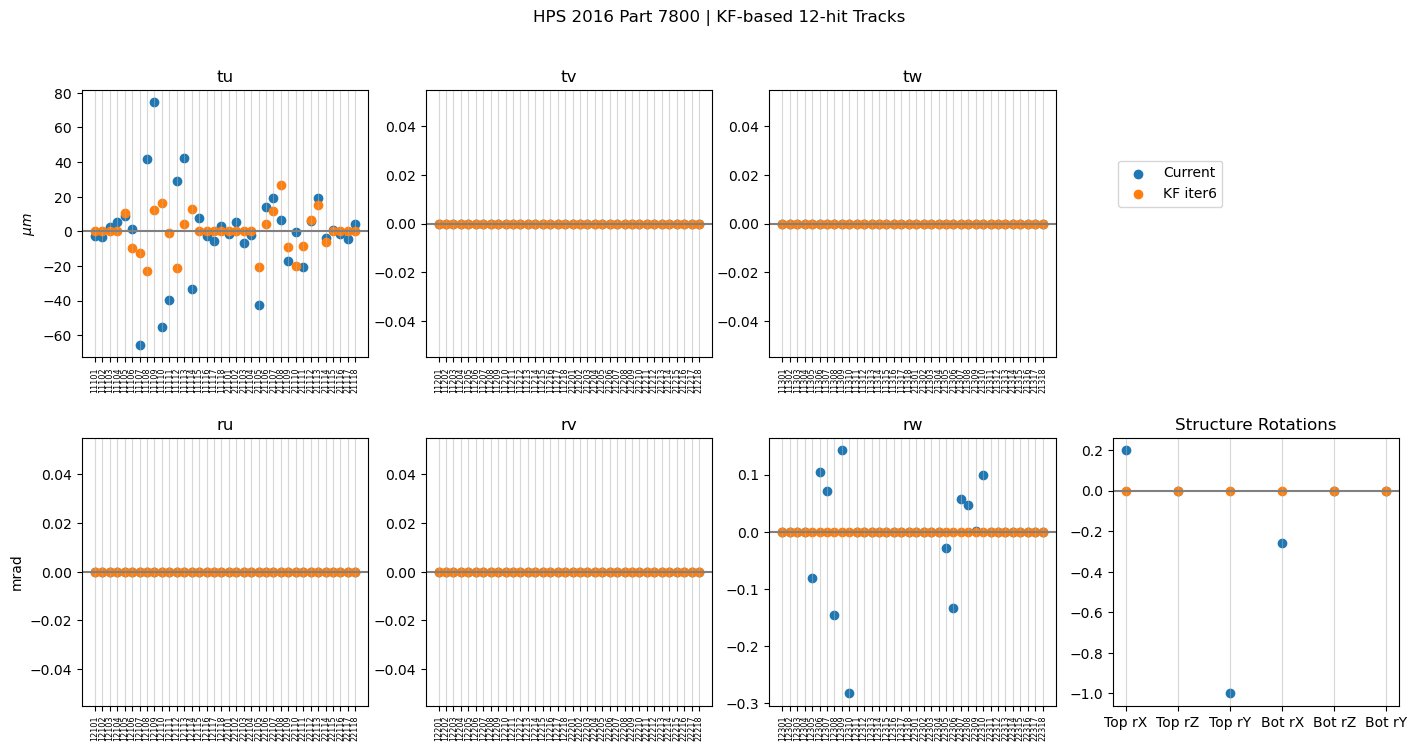

In [12]:
fig, axes = plt.subplots(
    nrows=2,ncols=4,
    gridspec_kw = dict(
        wspace = 0.2,
        hspace = 0.3
    )
)
fig.set_size_inches(17,8)

for tr, i_tr in [('t',1),('r',2)] :
    for uvw, i_uvw in [('u',1),('v',2),('w',3)] :
        ax = axes[i_tr-1][i_uvw-1]
        sl = (comp.t_r == i_tr)&(comp.u_v_w == i_uvw)
        for trk, name in [('st','Current'), ('kf','KF iter6')] :
            ax.scatter(comp[sl].parameter.apply(str), comp[sl][f'value_{trk}']*1000, 
                       label=name if (i_tr == 1 and i_uvw == 1) else '_no_legend')
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), 
                      rotation=90, fontsize='xx-small')
        ax.grid(axis='x', alpha=0.5)
        ax.axhline(0., color='gray')
        ax.set_title(f'{tr}{uvw}')
        if i_uvw == 1 :
            if i_tr == 1 :
                ax.set_ylabel('$\mu m$')
            elif i_tr == 2 :
                ax.set_ylabel('mrad')

axes[0][-1].axis('off')

structure_labeling = {
    13100 : 'Top rX',
    13200 : 'Top rZ',
    13300 : 'Top rY',
    23100 : 'Bot rX',
    23200 : 'Bot rZ',
    23300 : 'Bot rY'
}

for trk, name in [('st','Current'),('kf','KF FEEPass iter3')] :
    axes[1][-1].scatter(comp[~comp.individual].parameter.apply(lambda p : structure_labeling[p]),
                comp[~comp.individual][f'value_{trk}']*1000)
axes[1][-1].axhline(0., color='gray')
axes[1][-1].grid(axis='x', alpha=0.5)
axes[1][-1].set_title('Structure Rotations')

fig.legend(
    loc='upper right',
    bbox_to_anchor=(0.8,0.8)
)
fig.suptitle('HPS 2016 Part 7800 | KF-based 12-hit Tracks')
fig.savefig('st-vs-kf-constants.pdf')
plt.show()

In [1]:
def euler_angles(u, v, w):
    theta_x = np.arctan2(v[2], w[2])
    theta_y = -np.arcsin(u[2])
    theta_z = np.arctan2(u[1], u[0])
    return [theta_x, theta_y, theta_z]

def load_json(f):
    df = pd.read_json(f).transpose()
    df['theta'] = df.apply(
        lambda row: euler_angles(row.u, row.v, row.w),
        axis=1
    )
    df = df.explode(df.columns.values.tolist())
    df['coord'] = df.groupby(level=0).cumcount().apply(
        lambda c: 'x' if c==0 else 'y' if c==1 else 'z'
    )
    for meas in ['position','u','v','w','theta']:
        df[meas] = df[meas].astype(float)
    df.reset_index(names='sensor', inplace=True)
    # shorten sensor name
    df['sensor'] = df.sensor.apply(lambda s: s.replace('module0_','').replace('_sensor0','').replace('halfmodule_','').replace('module_',''))
    return df.set_index(['coord','sensor'])

In [9]:
dets = {
    d : load_json(f'HPS-PhysicsRun2016-{d}-global.json')
    for d in ['Pass2','KF-FEEPass-iter3']
}

In [13]:
# take difference between detectors, sort sensors by top/bottom, and drop ECalScoring planes
diff = (
    dets['KF-FEEPass-iter3']-dets['Pass2']
).reset_index().sort_values(
    'sensor',
    key = lambda sensors: sensors.str.lower().apply(lambda s: '0'+s if 't_' in s else '1'+s if 'b_' in s and 'ECal' not in s else '2'+s),
)
diff.drop(
    diff[diff.sensor.str.contains('ECalScoring')].index,
    inplace=True
)

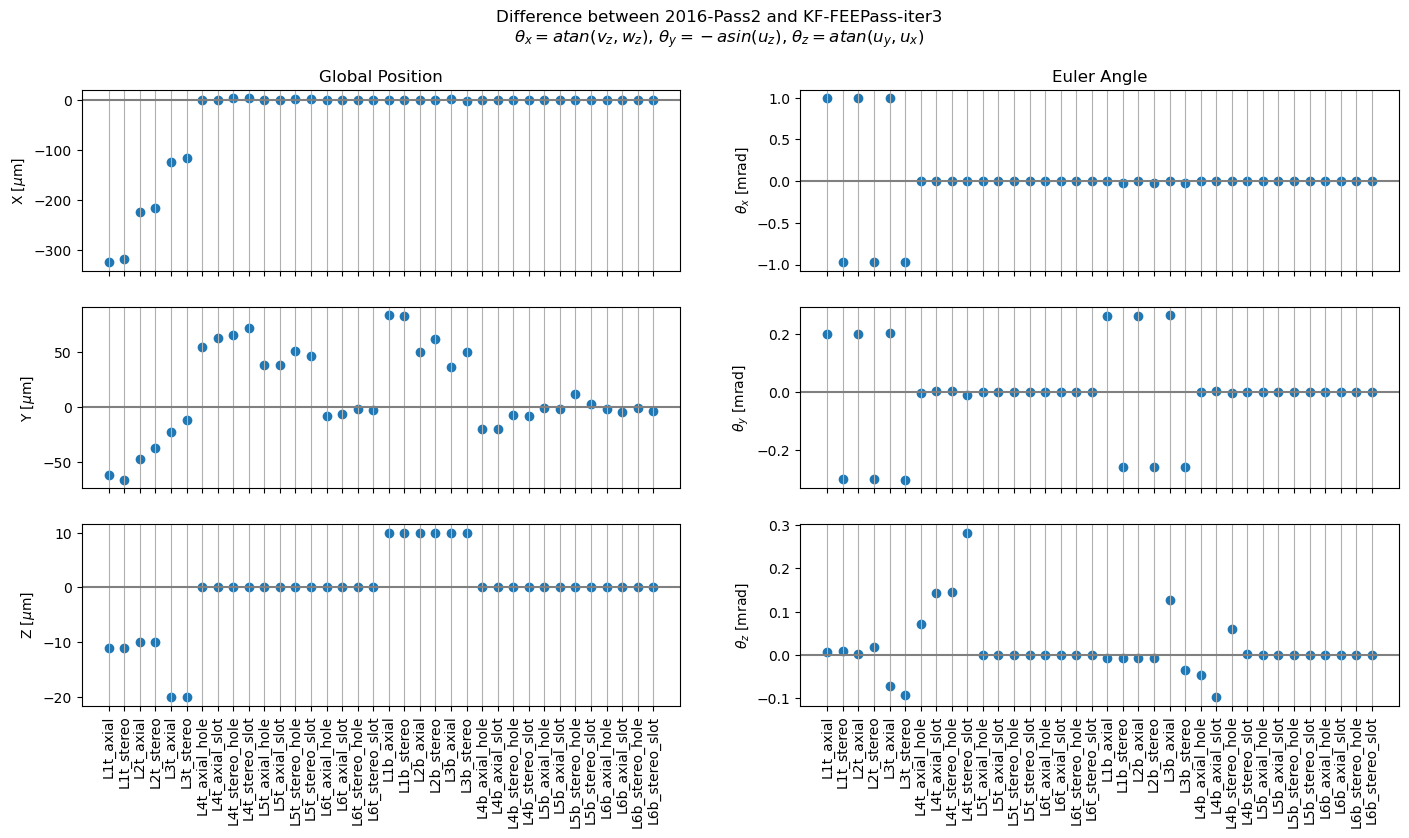

In [14]:
fig, axes = plt.subplots(
    nrows=3, ncols=2, sharex='col',
    gridspec_kw = dict(
        #wspace = 0.2,
        #hspace = 0.01
    )
)
fig.suptitle("""Difference between 2016-Pass2 and KF-FEEPass-iter3
$\\theta_x = atan(v_z, w_z)$, $\\theta_y = -asin(u_z)$, $\\theta_z = atan(u_y, u_x)$
""")
fig.set_size_inches(17,8)

for i_c, c in enumerate(['x','y','z']):
    for i_tr, tr in enumerate(['position','theta']):
        ax = axes[i_c][i_tr]
        ax.scatter(
            diff[diff.coord == c].sensor,
            diff[diff.coord == c][tr]*1000
        )
        if tr == 'position':
            ax.set_ylabel(f'{c.upper()} [$\mu$m]')
        else:
            ax.set_ylabel(f'$\\theta_{c}$ [mrad]')
        ax.axhline(0.0, color='gray')
        ax.grid(axis='x')
        if c == 'x':
            if tr == 'position':
                ax.set_title('Global Position')
            else:
                ax.set_title('Euler Angle')
        if c == 'z':
            ax.set_xticks(
                ax.get_xticks(),
                ax.get_xticklabels(),
                rotation=90
            )

plt.show()